# Batch Learning

In [5]:
import time
import sys
import warnings

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.datasets._samples_generator import make_regression
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def generate_dataset(n_train, n_test, n_features, noise=0.1):
    X, y = make_regression(
        n_samples=int(n_train + n_test),
        n_features=int(n_features),
        noise=noise,
        random_state=101,
    )

    X_train = X[:n_train]
    X_test = X[n_train:]

    y_train = y[:n_train]
    y_test = y[n_train:]
    
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    return X_train, X_test, y_train, y_test

In [4]:
n_test = 1000
n_train_v = (1_000, 10_000, 100_000)
n_features_v = (10, 50, 100, 500, 1_000)
regr_v = {'LR': LinearRegression(), 'SGD': SGDRegressor(random_state=101)}

results = {}

for regr_name, regr in regr_v.items():
    results[regr_name] = {}

    for n_train in n_train_v:
        for n_features in n_features_v:
            results[regr_name][(n_train, n_features)] = {'train': [], 'pred': []}
            for n_repetition in range(5):
                X_train, X_test, y_train, y_test = generate_dataset(n_train, n_test, n_features)

                tick = time.time()
                regr.fit(X_train, y_train)
                train_time = time.time() - tick

                pred = regr.predict(X_test)
                predict_time = time.time() - tick -train_time

                results[regr_name][(n_train, n_features)]['train'].append(train_time)
                results[regr_name][(n_train, n_features)]['pred'].append(predict_time)

In [8]:
pylab.rcParams['figure.figsize'] = 12, 6

def stat_plot(algorithm, type_):
    plt.subplot(1, 2, 1)

    for n_train in n_train_v:
        X = n_features_v
        y = [np.mean(results[algorithm][(n_train, n_features)][type_]) for n_features in n_features_v]
        plt.plot(X, y, label=str(n_train) + ' train points')

    plt.title('Training time VS num. features')
    plt.xlabel('Num features')
    plt.ylabel('Training time [s]')
    plt.legend(loc=0)

    plt.subplot(1, 2, 2)

    for n_features in n_features_v:
        X = np.log10(n_train_v)
        y = [np.mean(results[algorithm][(n_train, n_features)][type_]) for n_train in n_train_v]
        plt.plot(X, y, label=str(n_features) + ' features')

    plt.title('Training time VS num. training points')
    plt.xlabel('Num training points [log10]')
    plt.ylabel('Training time [s]')
    plt.legend(loc=0)

    plt.show()

Видно, что классификатор хорош для небольших наборов данных с небольшим количеством признаков.

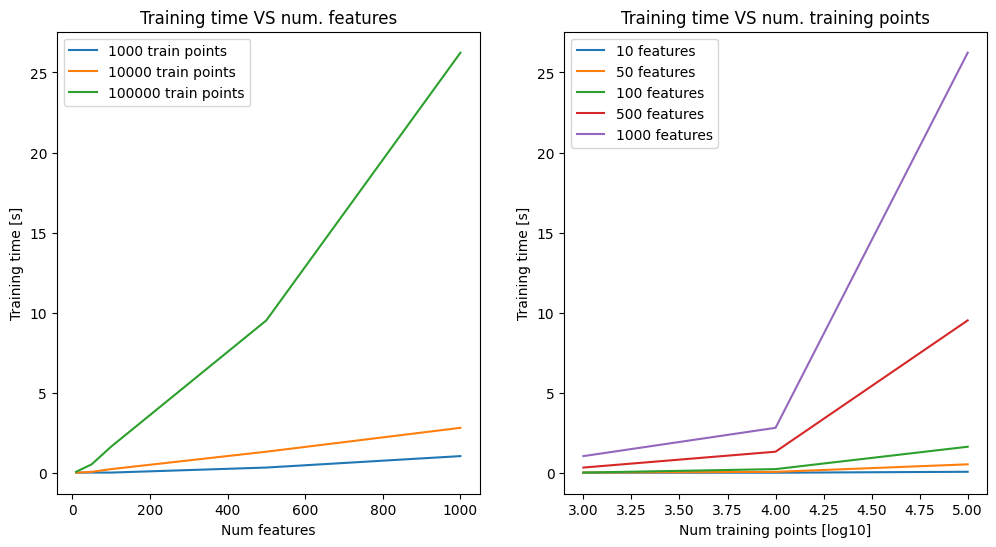

In [9]:
stat_plot('LR', 'train')

Время тестирования не зависит от количества функций

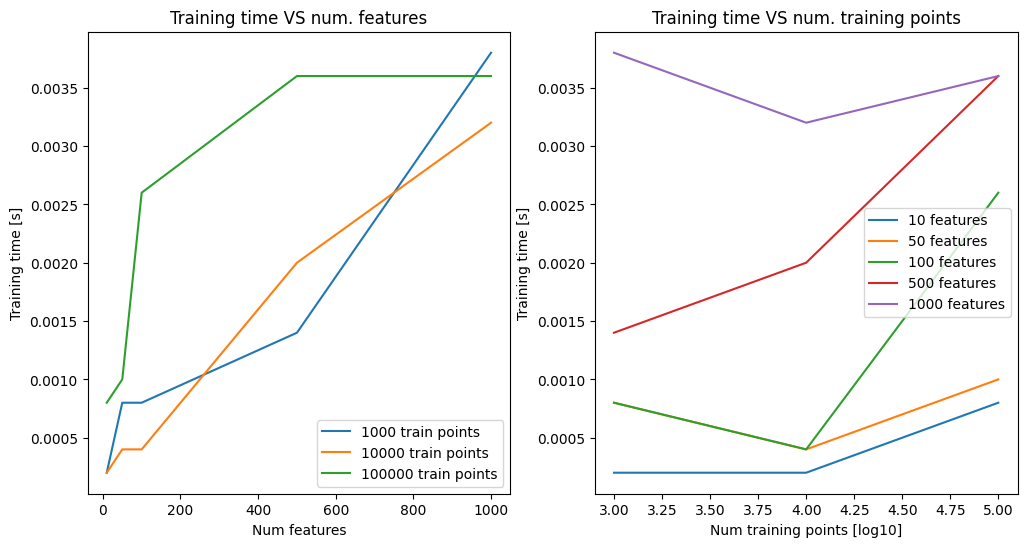

In [10]:
stat_plot('LR', 'pred')

На SGD обущающий прпоцесс занимает куда более меньшее время. SGD быстрее и масштабируется.

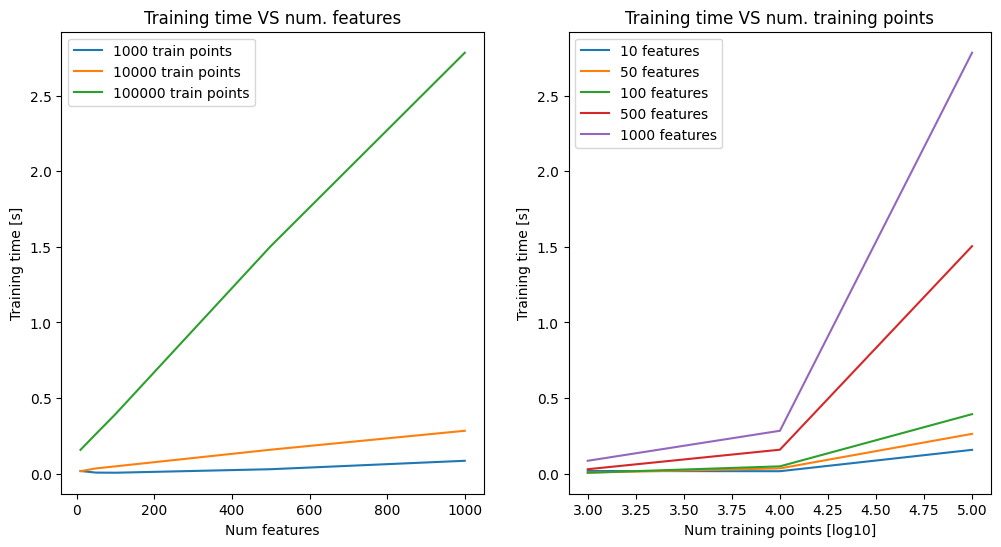

In [11]:
stat_plot('SGD', 'train')

Предсказание занимает столько же времени, как и для предыдущего алгоритма

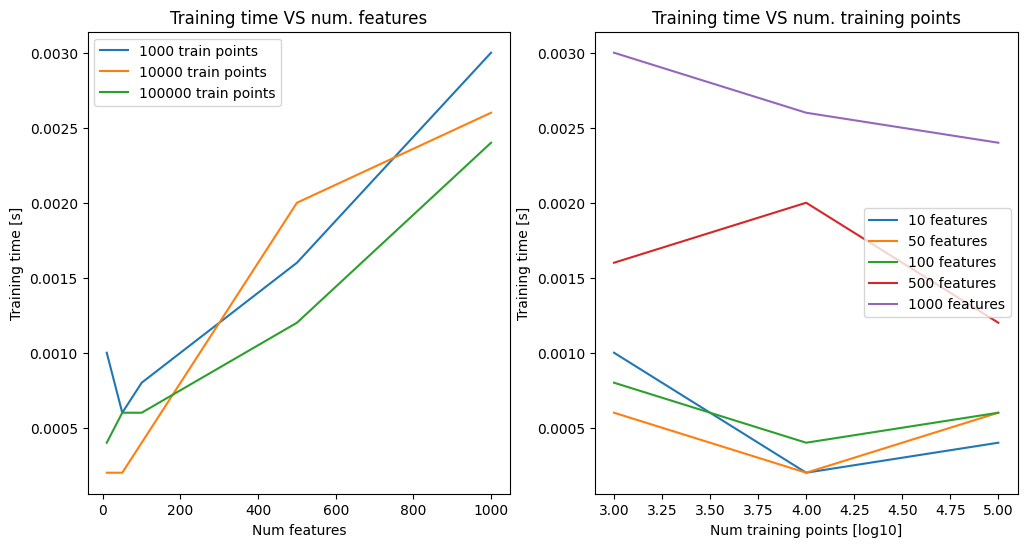

In [13]:
stat_plot('SGD', 'pred')

### Mini batch learning

In [5]:
X_train, X_test, y_train, y_test = generate_dataset(2_000_000, 10_000, 100, 10.0)
print(f'size [GB] ={X_train.size*X_train[0, 0].itemsize/1E9}')

size [GB] =1.6


Нужно улучшить эти показатели

In [7]:
regr = SGDRegressor(random_state=101)
tick = time.time()
regr.fit(X_train, y_train)
print(f'SGD, sfter {time.time() - tick} seconds')

pred = regr.predict(X_test)
print(f'MAE is [log10]= {np.log10(mean_absolute_error(y_test, pred))}')

SGD, sfter 11.831676721572876 seconds
MAE is [log10]= -1.2420868520071262


In [8]:
def get_minibatch(X, y, batch_size):
    from sklearn.utils import resample

    X, y = resample(X, y, replace=False, random_state=101)
    n_cols = y.shape[0]
    for i in range(int(n_cols/batch_size)):
        yield (X[i*batch_size: (i+1)*batch_size, :], y[i*batch_size: (i+1)*batch_size])

        if n_cols % batch_size > 0:
            res_rows = n_cols % batch_size
            yield (X[-res_rows:, :], y[-res_rows:])

Используя пакет в 1000 наблюдений, результат получаем через миллисекунду. Общее время пакетов куда меньше, чем 11.8 из предыдущего примера

In [10]:
plot_x = []
plot_y = []
plot_labels = []

for batch_size in (1_000, 10_000, 100_000):
    regr = SGDRegressor(random_state=101)
    training_time = 0.0

    X = []
    y = []

    for dataset in get_minibatch(X_train, y_train, batch_size):
        tick = time.time()
        regr.partial_fit(dataset[0], dataset[1])
        training_time += (time.time() - tick)
        pred = regr.predict(X_test)
        X.append(training_time)
        y.append(np.log10(mean_absolute_error(y_test, pred)))
    
    print(f'Mini-bacth size = {batch_size}')
    print(f'First output after [s] = {X[0]}')
    print(f'First model MAE [Log10] = {y[0]}')
    print(f'Total training time [s] = {X[-1]}')
    print(f'Final MAE [log10] = {y[-1]}\n')

    plot_x.append(X)
    plot_y.append(y)
    plot_labels.append(f'Batch size: {str(batch_size)}')

Mini-bacth size = 1000
First output after [s] = 0.0060002803802490234
First model MAE [Log10] = -0.9423203049428579
Total training time [s] = 4.008227348327637
Final MAE [log10] = -1.2403681920142031

Mini-bacth size = 10000
First output after [s] = 0.012000560760498047
First model MAE [Log10] = -1.231718628508888
Total training time [s] = 1.8851068019866943
Final MAE [log10] = -1.2403890347421407

Mini-bacth size = 100000
First output after [s] = 0.12100696563720703
First model MAE [Log10] = -1.2405392973210188
Total training time [s] = 1.8401055335998535
Final MAE [log10] = -1.240537903259327



График времени обучения с различными размерами пакетов

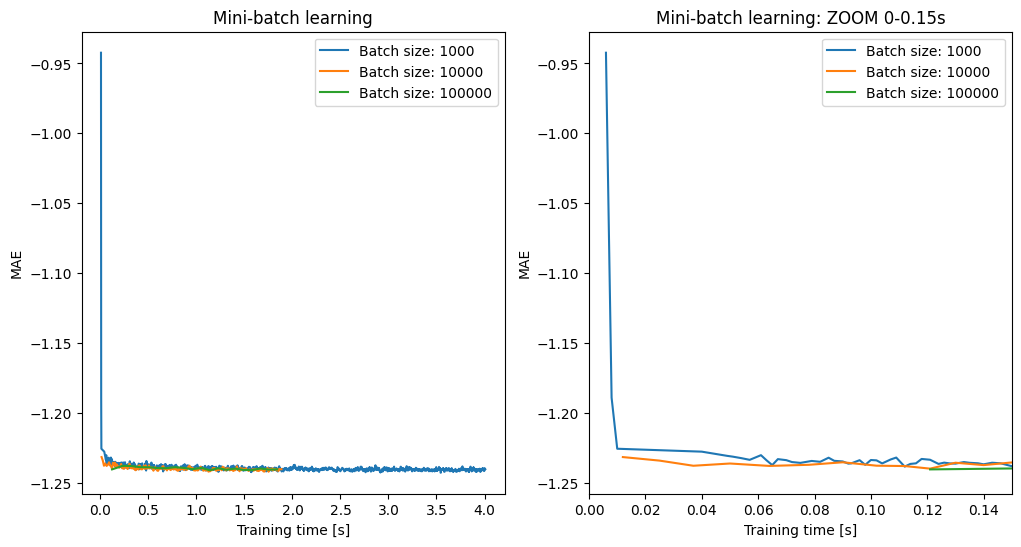

In [12]:
pylab.rcParams['figure.figsize'] = 12, 6
plt.subplot(1, 2, 1)

for i in range(len(plot_x)):
    plt.plot(plot_x[i], plot_y[i], label=plot_labels[i])

plt.title('Mini-batch learning')
plt.xlabel('Training time [s]')
plt.ylabel('MAE')
plt.legend(loc=0)

plt.subplot(1, 2, 2)

for i in range(len(plot_x)):
    plt.plot(plot_x[i], plot_y[i], label=plot_labels[i])

plt.title('Mini-batch learning: ZOOM 0-0.15s')
plt.xlabel('Training time [s]')
plt.ylabel('MAE')
plt.xlim([0, .15])
plt.legend(loc=0)

plt.show()

## 20 Newsgroups

In [2]:
to_remove = ('headers', 'footers', 'quotes')
data_train = fetch_20newsgroups(subset='train', random_state=101, remove=to_remove)
data_test = fetch_20newsgroups(subset='test', random_state=101, remove=to_remove)
labels = data_train.target_names
targets = np.unique(data_train.target)

In [3]:
def get_minibatch_docs(docs, targets, batch_size):
    '''Yield mini-batches of the dataset'''

    n_docs = len(docs)
    for i in range(int(n_docs/batch_size)):
        yield (docs[i*batch_size: (i+1)*batch_size], targets[i*batch_size: (i+1)*batch_size])
    

    if n_docs % batch_size > 0:
        res_rows = n_docs % batch_size
        yield (docs[-res_rows:], targets[-res_rows:])

Что бы понять, какой наилучший размер хэша, нужно попробовать выполнить полный поиск с размерами 1000, 5000, 10000, 50000, 100000, а затем измерить точность для каждого

In [10]:
minibatch_size = 1000
values_to_plot = {}

for hash_table_size in (1_000, 5_000, 10_000, 50_000, 100_000):
    values_to_plot[hash_table_size] = {'time': [], 'score': []}
    vectorizer = HashingVectorizer(stop_words='english', n_features=hash_table_size,
                                   ngram_range=(1, 1))
    X_test = vectorizer.transform(data_test.data)
    y_test = data_test.target

    clf = SGDClassifier(loss='log')
    timings = []

    for minibatch in get_minibatch_docs(data_train.data, data_train.target, minibatch_size):
        y_train = minibatch[1]

        tick = time.time()
        X_train = vectorizer.transform(minibatch[0])
        clf.partial_fit(X_train, y_train, targets)

        timings.append(time.time() - tick)
        pred = clf.predict(X_test)
        values_to_plot[hash_table_size]['score'].append(accuracy_score(y_test, pred))
    
    values_to_plot[hash_table_size]['time'] = np.cumsum(timings)

График времени и точности для каждого размера хэш-значения. Х - это случаи, когда классификатор выводит модель.

Использование хэш-таблиц более 10 000 элементов позволяет достичь лучшей производительности

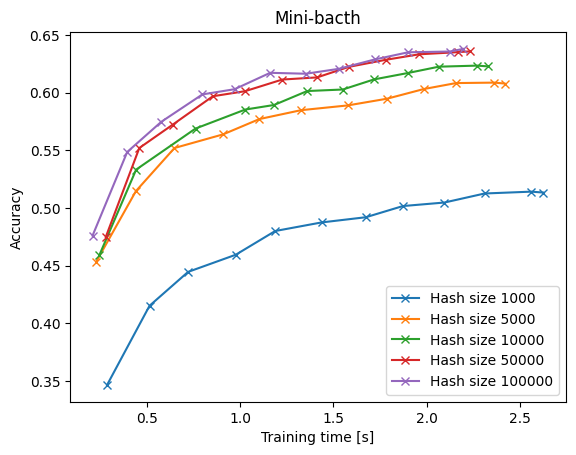

In [11]:
for k, v in sorted(values_to_plot.items()):
    plt.plot(v['time'], v['score'], 'x-', label=f'Hash size {k}')

plt.title('Mini-bacth')
plt.xlabel('Training time [s]')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()